# **TikTok Video Classification**

**Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**The purpose** is to mitigate misinformation in videos on the TikTok platform.

**The goal** is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>


## **Pace: Plan**

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np
from scipy import stats

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

Load the data from the provided csv file into a dataframe.

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

In [3]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [4]:
# Get number of rows and columns
data.shape

(19382, 12)

In [5]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [6]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


1. The dataframe contains a collection of categorical, text, and numerical data. Each row represents a distinct TikTok video that presents either a claim or an opinion and the accompanying metadata about that video.


2. The dataframe contains five float64s, three int64s, and four objects. There are 19,382 observations, but some of the variables are missing values, including claim status, the video transcripton, and all of the count variables.


3. Many of the count variables seem to have outliers at the high end of the distribution. They have very large standard deviations and maximum values that are very high compared to their quartile values.

In [7]:
#check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.

In [8]:
data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
19377    False
19378    False
19379    False
19380    False
19381    False
Length: 19382, dtype: bool

In [9]:
data.dropna(axis=0, inplace=True)

## **pAce: Analyze**

**Target variable**

The data dictionary shows that there is a column called `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable. In other words, for each video, the model should predict whether the video is a claim or an opinion.

This is a classification task because the model is predicting a binary class.


### Step 1 : EDA

In [10]:
# Check class balance
data["claim_status"].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

In [11]:
# average view count of videos with "claim" status
claims = data[data['claim_status']=='claim']
print('Mean view count claims:', claims['video_view_count'].mean())
print('Median view count claims:', claims['video_view_count'].median())

Mean view count claims: 501029.4527477102
Median view count claims: 501555.0


In [12]:
# average view count of videos with "opinion" status
opinion = data[data['claim_status']=='opinion']
print('Mean view count claims:', opinion['video_view_count'].mean())
print('Median view count claims:', opinion['video_view_count'].median())

Mean view count claims: 4956.43224989447
Median view count claims: 4953.0


* The mean and the median within each claim category are close to one another, but there is a vast discrepancy between view counts for videos labeled as claims and videos labeled as opinions.

Now, examine trends associated with the ban status of the author.

In [13]:
# Get counts for each group combination of claim status and author ban status
data.groupby(['claim_status','author_ban_status']).count()[['#']]

#
claim_status author_ban_status      
claim        active             6566
             banned             1439
             under review       1603
opinion      active             8817
             banned              196
             under review        463

There are many more claim videos with banned authors than there are opinion videos with banned authors. This could mean a number of things, including the possibilities that:-

* Claim videos are more strictly policed than opinion videos
* Authors must comply with a stricter set of rules if they post a claim than if they post an opinion
* Also, it should be noted that there's no way of knowing if claim videos are inherently more likely than opinion videos to result in author bans, or if authors who post claim videos are more likely to post videos that violate terms of service.

There's no way of determining whether a particular video caused the ban, and banned authors could have posted videos that complied with the terms of service.

* Continue investigating engagement levels, now focusing on **author_ban_status.**



In [14]:
data.groupby(['author_ban_status']).agg(
            {'video_view_count':['mean','median','count'],
            'video_like_count':['mean','median','count'],
            'video_share_count':['mean','median','count']})

video_view_count                  video_like_count  \
                              mean    median  count             mean   
author_ban_status                                                      
active               215927.039524    8616.0  15383     71036.533836   
banned               445845.439144  448201.0   1635    153017.236697   
under review         392204.836399  365245.5   2066    128718.050339   

                                   video_share_count                  
                     median  count              mean   median  count  
author_ban_status                                                     
active               2222.0  15383      14111.466164    437.0  15383  
banned             105573.0   1635      29998.942508  14468.0   1635  
under review        71204.5   2066      25774.696999   9444.0   2066

* Banned authors have a median video_share_count(14468) that's **33 times** the median video_share_count of active authors(437)

**What do you notice about the number of views, likes, and shares for banned authors compared to active authors?**

Now, create three new columns to help better understand engagement rates:
* `likes_per_view`: represents the number of likes divided by the number of views for each video
* `comments_per_view`: represents the number of comments divided by the number of views for each video
* `shares_per_view`: represents the number of shares divided by the number of views for each video

In [15]:
# Create a likes_per_view column
data['likes_per_view'] = data['video_like_count']/data['video_view_count']

# Create a comments_per_view column
data['comments_per_view'] = data['video_comment_count']/data['video_view_count']

# Create a shares_per_view column
data['shares_per_view'] = data['video_share_count']/data['video_view_count']

In [16]:
data.groupby(['claim_status','author_ban_status']).agg({'likes_per_view':['count','mean','median'],
                                                        'comments_per_view':['count','mean','median'],
                                                        'shares_per_view':['count','mean','median']})

likes_per_view                      \
                                        count      mean    median   
claim_status author_ban_status                                      
claim        active                      6566  0.329542  0.326538   
             banned                      1439  0.345071  0.358909   
             under review                1603  0.327997  0.320867   
opinion      active                      8817  0.219744  0.218330   
             banned                       196  0.206868  0.198483   
             under review                 463  0.226394  0.228051   

                               comments_per_view                      \
                                           count      mean    median   
claim_status author_ban_status                                         
claim        active                         6566  0.001393  0.000776   
             banned                         1439  0.001377  0.000746   
             under review                   1603  0.001367  0.000789   
opinion      active                         8817  0.000517  0.000252   
             banned                          196  0.000434  0.000193   
             under review                    463  0.000536  0.000293   

                               shares_per_view                      
                                         count      mean    median  
claim_status author_ban_status                                      
claim        active                       6566  0.065456  0.049279  
             banned                       1439  0.067893  0.051606  
             under review                 1603  0.065733  0.049967  
opinion      active                       8817  0.043729  0.032405  
             banned                        196  0.040531  0.030728  
             under review                  463  0.044472  0.035027

1. Videos by banned authors and those under review tend to get far more views, likes, and shares than videos by non-banned authors. However, when a video does get viewed, its engagement rate is less related to author ban status and more related to its claim status.


2. Claim videos have a higher view rate than opinion videos that means, claim videos also have a higher rate of likes on average, so they are more favorably received as well. Furthermore, they receive more engagement via comments and shares than opinion videos.


3. Note that for claim videos, banned authors have slightly higher likes/view and shares/view rates than active authors or those under review. However, for opinion videos, active authors and those under review both get higher engagement rates than banned authors in all categories.

#### Data Visulaization (EDA continue)

#### **video_duration_sec**

Create a box plot to examine the spread of values in the `video_duration_sec` column.

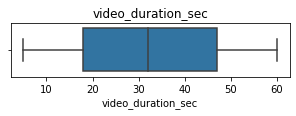

In [17]:
# Create a boxplot to visualize distribution of `video_duration_sec`

plt.figure(figsize=(5,1))
plt.title('video_duration_sec')
sns.boxplot(x=data['video_duration_sec']);

Create a histogram of the values in the `video_duration_sec` column to further explore the distribution of this variable.

<AxesSubplot:title={'center':'video duration histogram'}, xlabel='video_duration_sec', ylabel='Count'>

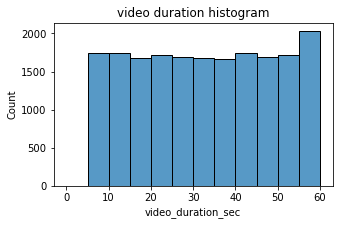

In [18]:
# Create a histogram

plt.figure(figsize=(5,3))
plt.title('video duration histogram')
sns.histplot(data['video_duration_sec'],bins=range(0,61,5))

* All videos are 5-60 seconds in length, and the distribution is uniform.**

#### **video_view_count**

Create a box plot to examine the spread of values in the `video_view_count` column.

Text(0.5, 1.0, 'video view count')

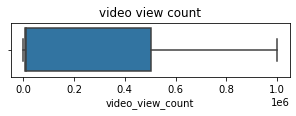

In [19]:
# Create a boxplot to visualize distribution of `video_view_count`

plt.figure(figsize=(5,1))
sns.boxplot(x=data['video_view_count'])
plt.title('video view count')

Create a histogram of the values in the `video_view_count` column to further explore the distribution of this variable.

Text(0.5, 1.0, 'video view count histogram')

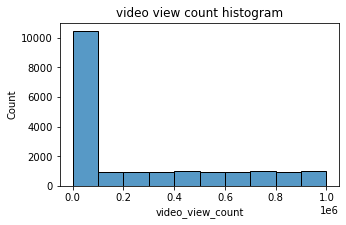

In [20]:
# Create a histogram

plt.figure(figsize=(5,3))
sns.histplot(data['video_view_count'],bins=range(0,(10**6+1),10**5))
plt.title('video view count histogram')

* This variable has a very uneven distribution, with more than half the videos receiving fewer than 100,000 views. Distribution of view counts > 100,000 views is uniform.**

#### **video_like_count**

Create a box plot to examine the spread of values in the `video_like_count` column.

Text(0.5, 1.0, 'video like count')

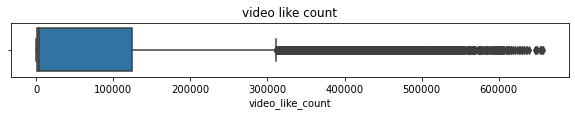

In [21]:
# Create a boxplot to visualize distribution of `video_like_count`

plt.figure(figsize=(10,1))
sns.boxplot(x=data['video_like_count'])
plt.title('video like count')

Create a histogram of the values in the `video_like_count` column to further explore the distribution of this variable.

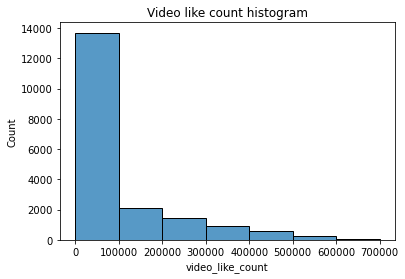

In [22]:
# Create a histogram

ax = sns.histplot(data['video_like_count'], bins=range(0,(7*10**5+1),10**5))
labels = [0] + [str(i) + 'k' for i in range(100, 701, 100)]
ax.set_xticks(range(0,7*10**5+1,10**5))
plt.title('Video like count histogram');

* Similar to view count, there are far more videos with < 100,000 likes than there are videos with more. However, in this case, there is more of a taper, as the data skews right, with many videos at the upper extremity of like count.

#### **video_comment_count**

Create a box plot to examine the spread of values in the `video_comment_count` column.

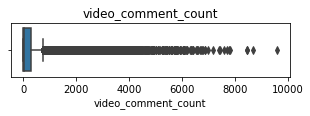

In [23]:
# Create a boxplot to visualize distribution of `video_comment_count`
plt.figure(figsize=(5,1))
plt.title('video_comment_count')
sns.boxplot(x=data['video_comment_count']);

Create a histogram of the values in the `video_comment_count` column to further explore the distribution of this variable.

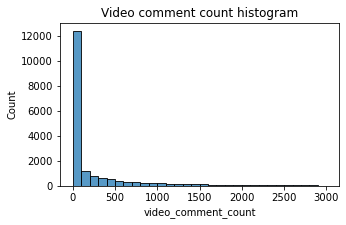

In [24]:
# Create a histogram

plt.figure(figsize=(5,3))
sns.histplot(data['video_comment_count'], bins=range(0,(3001),100))
plt.title('Video comment count histogram');

* Again, the vast majority of videos are grouped at the bottom of the range of values for video comment count. Most videos have fewer than 100 comments. The distribution is very right-skewed.

#### **video_share_count**

Create a box plot to examine the spread of values in the `video_share_count` column.

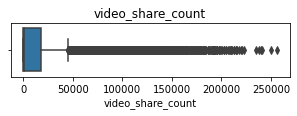

In [25]:
# Create a boxplot to visualize distribution of `video_share_count`

plt.figure(figsize=(5,1))
plt.title('video_share_count')
sns.boxplot(x=data['video_share_count']);

*Create* a histogram of the values in the `video_share_count` column to further explore the distribution of this variable.

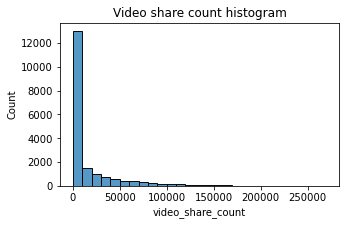

In [26]:
# Create a histogram
plt.figure(figsize=(5,3))
sns.histplot(data['video_share_count'], bins=range(0,(270001),10000))
plt.title('Video share count histogram');

* The overwhelming majority of videos had fewer than 10,000 shares. The distribution is very skewed to the right.**

#### **video_download_count**

Create a box plot to examine the spread of values in the `video_download_count` column.

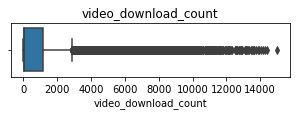

In [27]:
# Create a boxplot to visualize distribution of `video_download_count`
plt.figure(figsize=(5,1))
plt.title('video_download_count')
sns.boxplot(x=data['video_download_count']);


Create a histogram of the values in the `video_download_count` column to further explore the distribution of this variable.

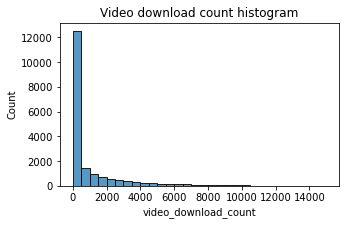

In [28]:
# Create a histogram
plt.figure(figsize=(5,3))
sns.histplot(data['video_download_count'], bins=range(0,(15001),500))
plt.title('Video download count histogram');

* The majority of videos were downloaded fewer than 500 times, but some were downloaded over 12,000 times. Again, the data is very skewed to the right.

#### **Claim status by verification status**

Now, create a histogram with four bars: one for each combination of claim status and verification status.

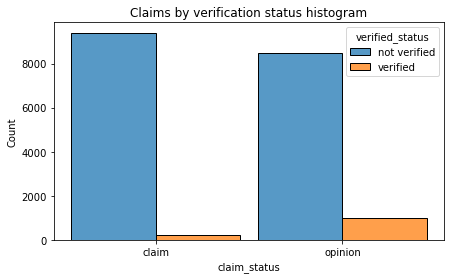

In [29]:
# Create a histogram
plt.figure(figsize=(7,4))
sns.histplot(data=data,
            x='claim_status',
            hue='verified_status',
            multiple='dodge',
            shrink=0.9)
plt.title('Claims by verification status histogram');

* There are far fewer verified users than unverified users, but if a user is verified, they are much more likely to post opinions.

#### **Claim status by author ban status**

The previous course used a `groupby()` statement to examine the count of each claim status for each author ban status. Now, use a histogram to communicate the same information.

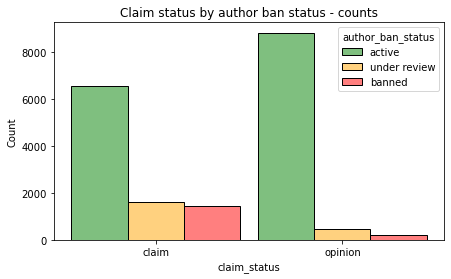

In [30]:
# Create a histogram

fig = plt.figure(figsize=(7,4))
sns.histplot(data, x='claim_status', hue='author_ban_status',
             multiple='dodge',
             hue_order=['active', 'under review', 'banned'],
             shrink=0.9,
             palette={'active':'green', 'under review':'orange', 'banned':'red'},
             alpha=0.5)
plt.title('Claim status by author ban status - counts');

*  For both claims and opinions, there are many more active authors than banned authors or authors under review; however, the proportion of active authors is far greater for opinion videos than for claim videos. Again, it seems that authors who post claim videos are more likely to come under review and/or get banned.

#### **Median view counts by ban status**

Create a bar plot with three bars: one for each author ban status. The height of each bar should correspond with the median number of views for all videos with that author ban status.

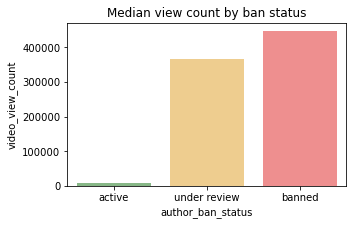

In [31]:
# Create a bar plot
ban_status_counts = data.groupby(['author_ban_status']).median(numeric_only=True).reset_index()

fig = plt.figure(figsize=(5,3))
sns.barplot(data=ban_status_counts,
           x='author_ban_status',
           y='video_view_count',
            order=['active', 'under review', 'banned'],
            palette={'active':'green', 'under review':'orange', 'banned':'red'},
            alpha=0.5)

plt.title('Median view count by ban status');

* The median view counts for non-active authors are many times greater than the median view count for active authors. Since you know that non-active authors are more likely to post claims, and that videos by non-active authors get far more views on aggregate than videos by active authors, then video_view_count might be a good indicator of claim status.

In [32]:
# Calculate the median view count for claim status.
data.groupby('claim_status').median()['video_view_count']

claim_status
claim      501555.0
opinion      4953.0
Name: video_view_count, dtype: float64

#### **Total views by claim status**

Create a pie graph that depicts the proportions of total views for claim videos and total views for opinion videos.

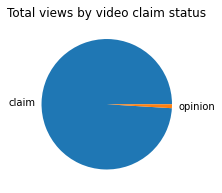

In [33]:
# Create a pie graph
fig = plt.figure(figsize=(3,3))
plt.pie(data.groupby('claim_status')['video_view_count'].sum(),labels=['claim','opinion'])
plt.title('Total views by video claim status');

* The overall view count is dominated by claim videos even though there are roughly the same number of each video in the dataset.

#### Determine outliers

When building predictive models, the presence of outliers can be problematic. For example, if you were trying to predict the view count of a particular video, videos with extremely high view counts might introduce bias to a model. Also, some outliers might indicate problems with how data was captured or recorded.

The ultimate objective of the TikTok project is to build a model that predicts whether a video is a claim or opinion. The performed analysis indicates that a video's engagement level is strongly correlated with its claim status. There's no reason to believe that any of the values in the TikTok data are erroneously captured, and they align with expectation of how social media works: a very small proportion of videos get super high engagement levels. That's the nature of viral content.

Nonetheless, it's good practice to get a sense of just how many of your data points could be considered outliers. The definition of an outlier can change based on the details of your project, and it helps to have domain expertise to decide a threshold. You've learned that a common way to determine outliers in a normal distribution is to calculate the interquartile range (IQR) and set a threshold that is **1.5 * IQR above the 3rd quartile**.

In this TikTok dataset, the values for the count variables are not normally distributed. They are heavily skewed to the right. One way of modifying the outlier threshold is by calculating the **median** value for each variable and then adding 1.5 * IQR. This results in a threshold that is, in this case, much lower than it would be if you used the 3rd quartile.

In [34]:
count_cols = ['video_view_count',
             'video_like_count',
             'video_share_count',
             'video_download_count',
             'video_comment_count']

for column in count_cols:
    q1=data[column].quantile(0.25)
    q3=data[column].quantile(0.75)
    iqr=q3-q1
    median = data[column].median()
    outlier_threshold = median + 1.5 * iqr
    
    outlier_count = (data[column] > outlier_threshold).sum()
    print(f'Number of outliers, {column}:', outlier_count)

Number of outliers, video_view_count: 2343
Number of outliers, video_like_count: 3468
Number of outliers, video_share_count: 3732
Number of outliers, video_download_count: 3733
Number of outliers, video_comment_count: 3882


#### **Scatterplot**

<AxesSubplot:xlabel='video_like_count', ylabel='video_comment_count'>

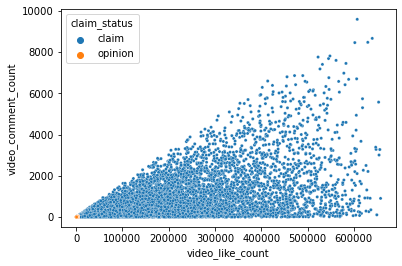

In [35]:
# Create a scatterplot of `video_like_count` versus `video_comment_count` according to 'claim_status'
sns.scatterplot(x=data['video_like_count'],y=data['video_comment_count'],hue=data['claim_status'],s=10)

<AxesSubplot:xlabel='video_like_count', ylabel='video_comment_count'>

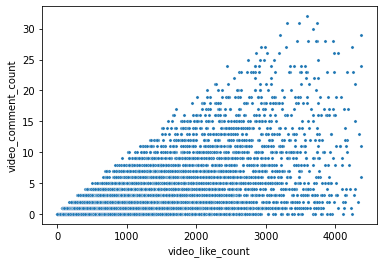

In [36]:
# Create a scatterplot of `video_like_count` versus `video_comment_count` for opinions only
opinion = data[data['claim_status']=='opinion']
sns.scatterplot(x=opinion['video_like_count'],y=opinion['video_comment_count'],s=10)

### Step 2: Hypothesis Testing

1. Null hypothesis: There is no difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to chance or sampling variability).

2. Alternative hypothesis: There is a difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to an actual difference in the corresponding population means).




Goal in this step is to conduct a two-sample t-test. Recall the steps for conducting a hypothesis test:


1.   State the null hypothesis and the alternative hypothesis
2.   Choose a signficance level
3.   Find the p-value
4.   Reject or fail to reject the null hypothesis



𝐻0 : There is no difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to chance or sampling variability).
𝐻𝐴 : There is a difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to an actual difference in the corresponding population means).

You choose 5% as the significance level and proceed with a two-sample t-test.

In [37]:
data.head(5)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175


Determine the relationship between `verified_status` and `video_view_count`. One approach is to examine the mean value of `video_view_count` for each group of `verified_status` in the sample data.

In [38]:
# Compute the mean `video_view_count` for each group in `verified_status`
### YOUR CODE HERE ###
data.groupby(['verified_status']).mean()[['video_view_count']]

,video_view_count
verified_status,
not verified,265663.785339
verified,91439.164167


In [39]:
# Conduct a two-sample t-test to compare means
### YOUR CODE HERE ###
not_verified = data[data['verified_status'] == 'not verified']['video_view_count']
verified = data[data['verified_status'] == 'verified']['video_view_count']

stats.ttest_ind(a=not_verified, b=verified, equal_var = False)

Ttest_indResult(statistic=25.499441780633777, pvalue=2.6088823687177823e-120)

* Since the p-value is extremely small (much smaller than the significance level of 5%), you reject the null hypothesis. You conclude that there is a statistically significant difference in the mean video view count between verified and unverified accounts on TikTok.

In [ ]:
# Not required but I want to see the distributions of the number of views per author status
fig, ax = plt.subplots(figsize=(12,6))
h = sns.histplot(data=data,x='video_view_count',hue='verified_status',bins='fd',element='step',alpha=0.4,
                  label=['not verified','verified'])
ax.set_yscale('log')
ax.set_xlabel("Video View Count",fontsize=16)
ax.set_ylabel("log Count",fontsize=16)
ax.set_title("View Counts for Verified/Unverified Authors",fontsize=20)
ax.axvline(x=verified_df['video_view_count'].mean(),c='r',ls='--')
ax.axvline(x=unverified_df['video_view_count'].mean())
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles,['Not Verified','Verified'],title='Author Status')
plt.tight_layout()
plt.savefig("View Counts.png",transparent=True)
plt.show()

* We should look into the content of unverified authors as there is a significant difference between the number of views between these two categories. Additionally, we would suggest into looking into the guidelines of making an author a verified author as this could provide some evidence regarding the type of content in these videos.

* The analysis shows that there is a statistically significant difference in the average view counts between videos from verified accounts and videos from unverified accounts. This suggests there might be fundamental behavioral differences between these two groups of accounts.

## **paCe: Construct**

**Select an evaluation metric**

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim



**What are the ethical implications of building the model?**
- In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.


**Modeling workflow and model selection process**

There are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

### **Step 3. Feature engineering**


Extract the length (character count) of each `video_transcription_text` and add this to the dataframe as a new column called `text_length` so that it can be used as a feature in the model.

In [40]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128


Calculate the average `text_length` for claims and opinions.



In [41]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions using a histogram.

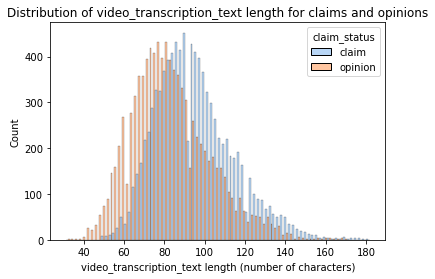

In [42]:
# Visualize the distribution of `video_transcription_text` length for claims and opinions
# Create two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about 13 more on average, as indicated in a previous cell.

**Feature selection and transformation**

Encode target and catgorical variables.

In [43]:
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128,0,0,0


### **Step 4. Split the data**

Assign target variable.

**Exemplar response:**
In this case, the target variable is `claim_status`.
* 0 represents an opinion
* 1 represents a claim

In [44]:
# Isolate target variable
y = X['claim_status']

Isolate the features.

In [45]:
# Isolate features
X = X.drop(['claim_status'], axis=1)

# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,0,0,1
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107,0,0,0
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137,0,0,0
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131,0,0,0
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128,0,0,0


### **Step 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [46]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [47]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [48]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 14), (3817, 14), (3817, 14), (11450,), (3817,), (3817,))

**Exemplar notes:**
- The number of features (`11`) aligns between the training and testing sets.
- The number of rows aligns between the features and the outcome variable for training (`11,450`) and both validation and testing data (`3,817`).

### Tokenize text column**

**NOTE:** You are not expected to do this or know this, but you might find it useful and/or interesting to understand some basic ideas behind natural language processing (NLP), because of the nature of the data provided in this TikTok project.

The feature `video_transcription_text` is text-based. It is not a categorical variable, since it does not have a fixed number of possible values. One way to extract numerical features from it is through a bag-of-words algorithm like [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

`CountVectorizer` works by splitting text into n-grams, which are groups of n consecutive words. For instance, "a dime for a cup of coffee" (phrase A) broken into 2-grams would result in six two-word combinations:

`a dime` | `dime for` |`for a`| `a cup` | `cup of` | `of coffee` |

Then, the next sample's text would be parsed into 2-grams. So, "ask for a cup for a child" (phrase B) would result in:

`ask for` |`for a`| `a cup` | `cup for` | `for a` | `a child` |

This process would repeat for each observation in the dataset, and each n-gram would be treated like a distinct feature. Then, the text of each observation is compared to the full array of n-grams, and the numbers of occurrences are tallied:

|  | `a dime` |`dime for`  |`for a`| `a cup` | `cup of` | `of coffee` | `ask for` | `cup for` | `a child` |
|--: |:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|phrase A |1|1|1|1|1|1|0|0|0|
|phrase B |0|0|2|1|1|0|1|1|1|
|**TOTAL**|1|1|3|2|2|1|1|1|1|

This would happen for the text of each observation in the data, and the text of each observation is parsed to get tallies for all the 2-word phrases from the entire data set for each observation, creating a large matrix.

If text is broken into 1-grams, then each feature in the matrix is an individual word.

After the count matrix has been created, `CountVectorizer` lets you the choose to keep only the most frequently occurring n-grams. You specify how many. The n-grams that you select can then be used as features in a model.

Splitting text into n-grams is an example of tokenization. Tokenization is the process of breaking text into smaller units to derive meaning from the resulting tokens.

This notebook breaks each video's transcription text into both 2-grams and 3-grams, then takes the 15 most frequently occurring tokens from the entire dataset to use as features.

In [49]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

Fit the vectorizer to the training data (generate the n-grams) and transform it (tally the occurrences). Only fit to the training data, not the validation or test data.

In [50]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [51]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,0.124648,0.000000,0.008042,134,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,0.029896,0.000245,0.003156,97,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,0.017799,0.000085,0.002162,76,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,0.180638,0.000433,0.047593,58,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,0.174097,0.000264,0.016618,57,...,0,0,0,0,0,0,0,0,0,0


Get n-gram counts for the validation data. Notice that the vectorizer is not being refit to the validation data. It's only transforming it. In other words, the transcriptions of the videos in the validation data are only being checked against the n-grams found in the training data.

In [53]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [54]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [55]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,0.655730,0.000076,0.025241,72,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,0.273221,0.000160,0.049720,96,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,0.608530,0.003051,0.063932,88,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,0.063862,0.000609,0.003023,83,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,0.142063,0.000995,0.026034,104,...,0,0,0,0,0,0,0,1,0,0


Repeat the process to get n-gram counts for the test data. Again, don't refit the vectorizer to the test data. Just transform it.

In [56]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,0.196444,0.000451,0.023973,107,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,0.359799,0.000194,0.006971,69,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,0.429157,0.003669,0.071835,90,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,0.359932,0.000778,0.131747,76,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,0.192276,0.000164,0.027615,72,...,0,0,0,0,0,0,0,0,0,0


### **Step 6. Build models**

### **Build a random forest model**


Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [57]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

Note this cell might take several minutes to run.

In [58]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: user 7min 31s, sys: 2.38 s, total: 7min 34s
Wall time: 7min 37s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'f1', 'precision', 'recall', 'accuracy'})

In [59]:
# Examine best recall score
rf_cv.best_score_

0.9958582006702817

In [60]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

**Exemplar response:**

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

### **Build an XGBoost model**

In [61]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

Note this cell might take several minutes to run.

In [62]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 26min 34s, sys: 3min 25s, total: 29min 59s
Wall time: 4min 8s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [63]:
xgb_cv.best_score_

0.9925792141101926

In [64]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.

## **pacE: Execute**

### **Step 7. Evaluate models**

Evaluate models against validation data.

#### **Random forest**

In [65]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

Display the predictions on the validation set.

In [66]:
# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1])


Display the true labels of the validation set.

In [67]:
# Display the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

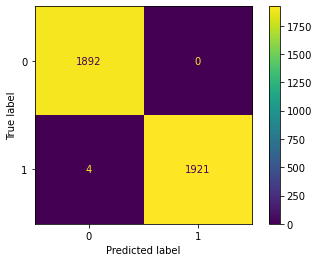

In [68]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

**Exemplar notes:**

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model does not produce any false negatives.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.
<br> </br>

**Note:** In other labs there was a custom-written function to extract the accuracy, precision, recall, and F<sub>1</sub> scores from the GridSearchCV report and display them in a table. You can also use scikit-learn's built-in [`classification_report()`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) function to obtain a similar table of results.

In [69]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Exemplar response:**

The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 10 misclassifications&mdash;five false postives and five false negatives.

#### **XGBoost**

Now, evaluate the XGBoost model on the validation set.

In [70]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

In [71]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

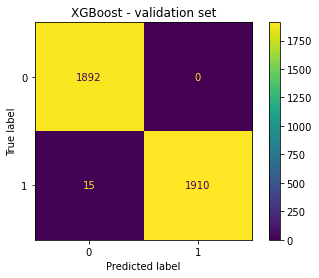

In [72]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [73]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1892
       claim       1.00      0.99      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

### **Use champion model to predict on test data**

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case random forest performed a little bit better, so it is the champion model.

Now, use the champion model to predict on the test data.

In [74]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

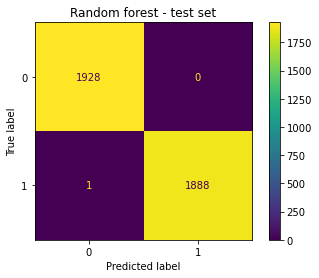

In [75]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

#### **Feature importances of champion model**



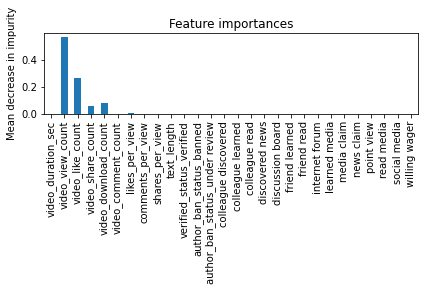

In [76]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

### **Conclusion**

**1. Would you recommend using this model? Why or why not?**
* Yes, one can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.



**2. What was your model doing? Can you explain how it was making predictions?**
* The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.



**3. Are there new features that you can engineer that might improve model performance?**
* Because the model currently performs nearly perfectly, there is no need to engineer any new features.



**4. What features would you want to have that would likely improve the performance of your model?**
* The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.
